## Draft of UCT for active learning strategy using clusters
* Refactor UCT to use only X (known) and playout faster
* Add scorer using clusters
* Test 
* Add UCT game selecting from clusters and then sampling

In [78]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.insert(0, "/lhome/home/jastrzebski/mlls2015/")
sys.path.insert(0, "..")
import misc
from collections import defaultdict
import copy, math, sys
import numpy as np
from collections import namedtuple
import copy
from sklearn.utils import check_random_state
import sys
sys.path.append("..")
from misc.config import *
from misc.utils import *
config_log_to_file("uct_circle_and_cross.log", level=logging.INFO)
logger = logging.getLogger("uct_circle_and_cross")
import time, random
from functools import partial
import models
from sklearn.cluster import KMeans
import seaborn
from models.uct import *
import matplotlib.pylab as plt
%matplotlib inline
import sklearn
from alpy2.uct_strategy import *
from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron
from alpy2.utils import mask_unknowns, unmasked_indices, masked_indices
from alpy2.strategy import *
from sklearn.metrics import pairwise_distances
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def normalized_euclidean_pairwise_distances(X):
    """ d(i, j) = ||xi - xj||/max(||xk - xl||)"""
    D = pairwise_distances(X, metric="euclidean")
    return D / D.max()

def exponential_pairwise_distances(x1, x2):
    """ d(i, j) = exp(-||xi - xj||)"""
    D = pairwise_distances(X, metric="euclidean")
    return 1 - np.exp(-D)

# Data generation

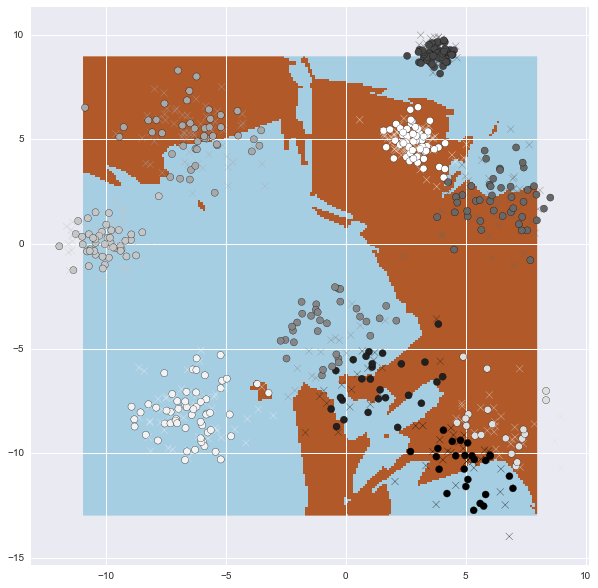

In [79]:
rng = 10
rng = check_random_state(rng)

def gauss_sample(N, K, D=2):
    mean = rng.uniform(-10,10, size=(N,D))
    dev = rng.uniform(0.1, 2, size=(N,))
    size = rng.uniform(0.5*K, 1.5*K, size=(N,))
    X = []
    y = []
    for m,d,s in zip(mean, dev,size):
        X.append(rng.normal(m, d, size=(K,D)))
        y.append((rng.uniform(0, 1, size=(K)) > 0.5).astype("int"))
    return np.vstack(X), np.hstack(y)

### Sample some data from multivariate gauss distribution ###
X, y = gauss_sample(8, 100, 2)
m = KMeans(n_clusters=10).fit_predict(X)
# hyperplane = rng.uniform(0,1,size=(3,))
# y = np.array([hyperplane[0:2].dot(p.reshape(-1,1)) + hyperplane[2] >= 0 for p in X]).reshape(-1)

samples = rng.choice(range(X.shape[0]), 120)
y = mask_unknowns(y, range(len(y)))
# Unmask part of data
y[samples] = y.data[samples] 


m = KMeans(n_clusters=10).fit_predict(X)
# model = Perceptron().fit(X[samples], y[samples]) 
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10).fit(X[samples], y[samples]) 
plt.figure(figsize=(10,10))


# Plot the decision boundary. For that, we will assign a color to each
h = 0.1
x_min, x_max = X[:, 0].min() + 1, X[:, 0].max() - 1
y_min, y_max = X[:, 1].min() + 1, X[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# True example labels
for mark, cls in zip(['o','x'], [0,1]):
    plt.scatter(X[y.data==cls, 0], X[y.data==cls, 1],s=50,c = m[y.data==cls], marker=mark)

In [80]:
def uqgb_strategy(game, N=2000, policy=ucb_policy, _use_playout_and_score=True, solver="iterative", rng=777):
    state = {"ids": [], "cluster_ids": []}
    if solver == "iterative":
        for i in range(batch_size):
            uct = UCT(N=N, game=game, rng=777, policy=policy, progressive_widening=False, \
                      _use_playout_and_score=_use_playout_and_score)
            uct.partial_fit(state, N=N)
            state = uct.best_path_[1].state # Next after root
            assert len(state['ids'])== i+1
    elif solver == "single":
        uct = UCT(N=N*game.batch_size, rng=777, game=game, policy=policy, progressive_widening=False,_use_playout_and_score=_use_playout_and_score)
        uct.fit(state)
        state = uct.playout(uct.best_path_[-1].state, N=N)
        assert len(state['ids']) == game.batch_size
    else:
        raise RuntimeError("Not implemented solver")
    return state['ids'], state['cluster_ids']

# Using UCT for optimization in cluster case

In [81]:
# Params
distance_cache = normalized_euclidean_pairwise_distances(X)
batch_size = 20
c = 0.8
rng = 777
K = 200 
picking_function = "prop"

# Prepare data. SetFunctionOptimizerGame wants unknown indices, whereas QuasiGreedyBatchScorer works on 
# global indexing
X_unknown = X[masked_indices(y)]
kmeans = KMeans(n_clusters=K).fit(X_unknown)
unknown_clustering = kmeans.predict(X_unknown)
X_clustered = [np.where(unknown_clustering==id)[0].tolist() for id in set(unknown_clustering.tolist())]

# Playing clases
base_strategy = UncertaintySampling()
scorer = QuasiGreedyBatchScorer(X, y, distance_cache=distance_cache, base_strategy=base_strategy, \
                                model=model, c=c, rng=rng, batch_size=batch_size, \
                                unknown_clustering=unknown_clustering, optim=2)
game_cluster = SetFunctionOptimizerGame(rng=777, X=X_clustered, scorer=scorer, batch_size=batch_size, \
                               element_picking_function=picking_function)
game = SetFunctionOptimizerGame(rng=777, X=X[masked_indices(y)], scorer=scorer, batch_size=batch_size)

# Simplest launch

In [82]:
strategy = QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=1)
qgb_solution = strategy(X, y, rng=np.random.RandomState(777), 
                               model=model, batch_size=20, return_score=False)
uqgb_solution, uqgb_solution_cids = uqgb_strategy(game=game_cluster, N=100)
print "QGB(n_tries=1):", scorer.score(qgb_solution, remap=False)
print "UCT:", scorer.score(uqgb_solution)
print "Picked ids", uqgb_solution

# Simple tests: picks from clusters, doesn't repeat clusters
assert len(uqgb_solution) == batch_size
uqgb_solution_cids2 = [kmeans.predict(X_unknown[id:id+1])[0] for id in uqgb_solution] 
print uqgb_solution_cids
print uqgb_solution_cids2
assert np.array_equal(uqgb_solution_cids, uqgb_solution_cids2)
assert len(set(uqgb_solution_cids2)) == len(uqgb_solution_cids2)

QGB(n_tries=1): 0.489268308439
UCT: 0.42893278536
Picked ids [399, 376, 412, 638, 625, 396, 62, 3, 342, 299, 264, 373, 339, 504, 483, 488, 28, 277, 33, 52]
[82, 47, 69, 22, 91, 72, 17, 92, 81, 96, 3, 85, 39, 100, 68, 32, 30, 116, 105, 117]
[82, 47, 69, 22, 91, 72, 17, 92, 81, 96, 3, 85, 39, 100, 68, 32, 30, 116, 105, 117]


# Experiments

In [68]:
# Without clusters
scores = []
for N in np.linspace(50, 5000, 5):
    scores.append(scorer.score(uqgb_strategy(game=game, N=int(N))[0]))
    print scores, N

[0.1576768518749036] 50.0
[0.1576768518749036, 0.525928692566721] 1287.5
[0.1576768518749036, 0.525928692566721, 0.5402149712411981] 2525.0
[0.1576768518749036, 0.525928692566721, 0.5402149712411981, 0.5444351863861083] 3762.5
[0.1576768518749036, 0.525928692566721, 0.5402149712411981, 0.5444351863861083, 0.5498520635303698] 5000.0


In [83]:
# With clusers
scores_cluster = []
for N in np.linspace(50, 5000, 5):
    N = int(N)
    scores_cluster.append(scorer.score(uqgb_strategy(game=game_cluster, N=N)[0]))
    print scores_cluster

[0.4128229960642363]
[0.4128229960642363, 0.47660903416181866]
[0.4128229960642363, 0.47660903416181866, 0.47525607498068556]
[0.4128229960642363, 0.47660903416181866, 0.47525607498068556, 0.47692856700796826]
[0.4128229960642363, 0.47660903416181866, 0.47525607498068556, 0.47692856700796826, 0.4842708937745345]


In [70]:
# Ugly way to get QGB scores
scores_qgb = [scorer.score(QuasiGreedyBatch(distance_cache=distance_cache, c=c, n_tries=int(np.sqrt(n)+1))\
              (X, y, rng=np.random.RandomState(777),model=model, batch_size=20, return_score=False), remap=False) for n in Ns]

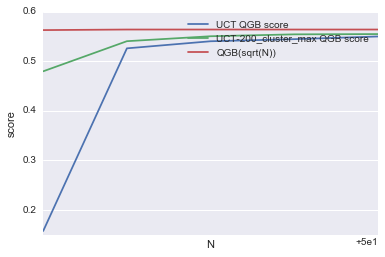

In [75]:
plt.plot(scores, label="UCT QGB score")
plt.plot(scores_cluster, label="UCT-{}_cluster_max QGB score".format(K))
plt.xlabel("N")
plt.xticks(Ns)
plt.ylabel("score")
plt.plot(scores_qgb, label="QGB(sqrt(N))")
# plt.plot([scorer.score(qgb_solution, remap=False) for _ in range(len(scores))], label="QGB(n_tries=2) score")
plt.legend()